In [48]:
import sys, os
import numpy as np
sys.path.append('../../../../')
import FHMCAnalysis
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_hist as hG
import FHMCAnalysis.moments.win_patch.chkpt_patch as wP
import FHMCAnalysis.moments.win_patch.chkpt_equil as wE

import matplotlib.pyplot as plt
%matplotlib inline

colors = ['r', 'g', 'b', 'orange', 'c', 'm', 'y', 'k'] 

# Generate and Collect the Histograms

In [49]:
temp = 0.95 # Choose a temperature to look at, T = [0.95, 1.10, 1.20]

### Patching was already done for this example, but it would look something like this
```
head = './T=%2.2f'%temp # Directory where data is
trim = 1 # Trim one point from the egde of each histogram when combining
smoothOverlap = True # Smooth the overlapping histograms
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    try:
        src = head+'/'+d
        seq = wP.get_patch_sequence(src)
        seq = wE.test_nebr_equil(seq, 3.0, src+'/maxEq', True) # 3% max error, trust last histogram found that satisfies this
        composite = src+'/composite.nc'
        wP.patch_all_windows(seq, composite, src+'/patch.log', trim, smoothOverlap)
    except:
        pass
```

In [50]:
# Collect the histograms

smooth = 20 # How many points in N_tot space to smooth lnPI over when looking for maxima
histograms = {}
for kt in [1.20, 1.10, 0.95]:
    beta_ref = 1.0/kt
    head = './T=%2.2f'%kt
    histograms[kt] = {}
    for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
        composite = head+'/'+d+'/composite.nc'
        try:
            f = open(composite,'r')
        except:
            pass
        else:
            dMu2 = float(d.split('_')[1])
            mu_ref = [0.0, 0.0+dMu2] # Simulations were performed at mu_1 = 0 in the simulation data provided
            hist = hG.histogram (composite, beta_ref, mu_ref, smooth)
            histograms[kt][dMu2] = hist

# First, Extrapolate in Delta Mu2 only

In [51]:
order = 2 # Second order extrapolation

In [52]:
mu1 = -5.1 # Choose some arbitrary mu_1 to make comparisons at

In [53]:
kt_ref = 1.20 # Choose a temperature to extrapolate from
dmu2_base = 0.0 # Choose a dMu2 to extrapolate from

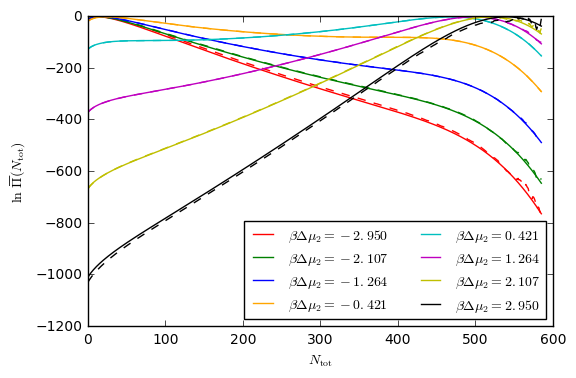

In [58]:
ctr = 0
histograms[kt_ref][dmu2_base].reweight(mu1)
max_err = {}
max_err_n = {}
for dmu2 in sorted(histograms[kt_ref])[::2]:
    try:
        histograms[kt_ref][dmu2].reweight(mu1)
        clone = histograms[kt_ref][dmu2_base].temp_dmu_extrap(1.0/kt_ref, np.array([dmu2]), order)
        if (True): #clone.is_safe() and histograms[kt_ref][dmu2].is_safe()): 
            ms = np.min([len(histograms[kt_ref][dmu2].data['ln(PI)']), len(clone.data['ln(PI)'])])
            plt.plot(clone.data['ln(PI)'][:ms], '--', color=colors[ctr])
            plt.plot(histograms[kt_ref][dmu2].data['ln(PI)'][:ms], color=colors[ctr], label=r'$\beta \Delta \mu_2 = %.3f$'%(dmu2/kt_ref))
            loc = np.where(histograms[kt_ref][dmu2].data['ln(PI)'][:ms] == np.max(histograms[kt_ref][dmu2].data['ln(PI)'][:ms]))
            max_err[dmu2] = histograms[kt_ref][dmu2].data['ln(PI)'][loc] - clone.data['ln(PI)'][loc]
            max_err_n[dmu2] = loc[0] - np.where(clone.data['ln(PI)'] == np.max(clone.data['ln(PI)']))[0]
        ctr += 1
    except:
        pass
    
plt.xlabel(r'$N_{\rm tot}$')
plt.ylabel(r'${\rm ln}\ \widebar{\Pi} (N_{\rm tot})$')
    
plt.legend(loc=4, ncol=2, fontsize=10)

# Extrapolate in both T and dMu2

In [59]:
kt_target = 1.10 # Choose a new target temperature, T = [0.95, 1.10, 1.20]

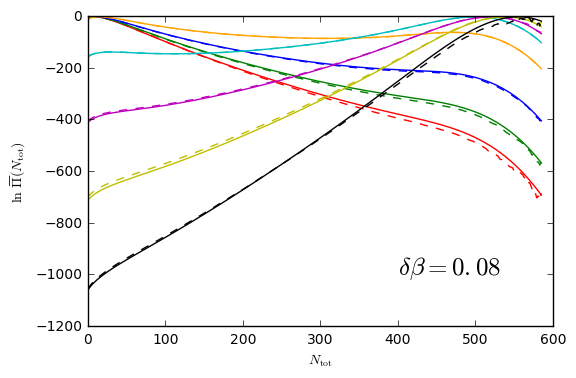

In [65]:
target_beta = 1.0/kt_target

ctr = 0
max_err2 = {}
max_err2_n = {}
histograms[kt_ref][dmu2_base].reweight(mu1)

for dmu2 in sorted(histograms[kt_target])[::2]:
    histograms[kt_target][dmu2].reweight(mu1)
    clone = histograms[kt_ref][dmu2_base].temp_dmu_extrap(target_beta, np.array([dmu2]), order)
    if (True): #clone.is_safe() and histograms[kt_target][dmu2].is_safe()):
        ms = np.min([len(histograms[kt_target][dmu2].data['ln(PI)']), len(clone.data['ln(PI)'])])
        plt.plot(clone.data['ln(PI)'][:ms], '--', color=colors[ctr])
        plt.plot(histograms[kt_target][dmu2].data['ln(PI)'][:ms], color=colors[ctr], label='$\beta \Delta \mu = %.3f$'%(dmu2/kt_target))
        loc = np.where(histograms[kt_target][dmu2].data['ln(PI)'][:ms] == np.max(histograms[kt_target][dmu2].data['ln(PI)'][:ms]))
        max_err2[dmu2] = histograms[kt_target][dmu2].data['ln(PI)'][loc] - clone.data['ln(PI)'][loc]
        max_err2_n[dmu2] = loc[0] - np.where(clone.data['ln(PI)'] == np.max(clone.data['ln(PI)']))[0]
    ctr += 1
plt.xlabel(r'$N_{\rm tot}$')
plt.ylabel(r'${\rm ln}\ \widebar{\Pi} (N_{\rm tot})$')

plt.text(400, -1000, r'$\delta \beta = %.2f$'%(1.0/1.10 - 1.0/1.20), fontsize=18)

# Compare error at most likely state

In [70]:
x1 = np.array(sorted([k for k in max_err]))
x2 = np.array(sorted([k for k in max_err2]))

In [71]:
a1 = [-max_err[k] for k in x1]
a2 = [-max_err2[k] for k in x2]

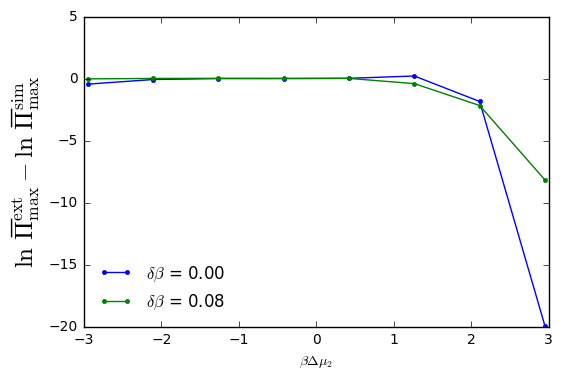

In [74]:
plt.plot(x1/1.20, a1, '.-', label=r'$\delta \beta$ = %.2f'%(1.0/kt_ref-1.0/kt_ref))
plt.plot(x2/1.10, a2, '.-', label=r'$\delta \beta$ = %.2f'%(1.0/kt_target-1.0/kt_ref))
plt.xlabel(r'$ \beta \Delta \mu_2$')
plt.ylabel(r'${\rm ln}\ \widebar{\Pi}_{\rm max}^{\rm ext} - {\rm ln}\ \widebar{\Pi}_{\rm max}^{\rm sim}$', fontsize=18)
plt.legend(loc=3, frameon=False)

# Compare the resulting density error

In [77]:
V = 9.0**3 # This was the volume of the simulation cell used in the sample data provided
b1 = [-max_err_n[k]/V for k in x1]
b2 = [-max_err2_n[k]/V for k in x2]

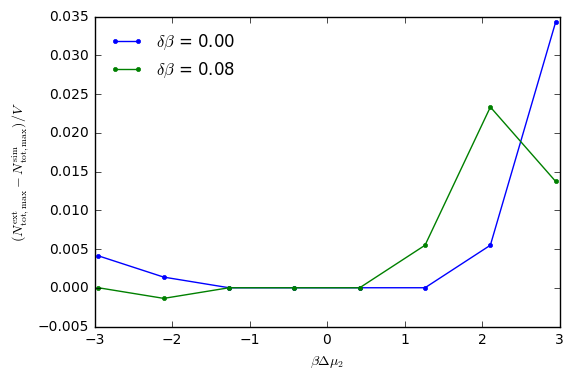

In [78]:
plt.plot(x1/1.20, b1, '.-', label=r'$\delta \beta$ = %.2f'%(1.0/kt_ref-1.0/kt_ref))
plt.plot(x2/1.10, b2, '.-', label=r'$\delta \beta$ = %.2f'%(1.0/kt_target-1.0/kt_ref))
plt.xlabel(r'$\beta \Delta \mu_2$')
plt.ylabel(r'$(N_{\rm tot, max}^{\rm ext} - N_{\rm tot, max}^{\rm sim})/V$')
plt.legend(loc=2, frameon=False)